# 03: Transpilation of quantum circuits

In this hands-on exercise, we show more in detail how the circuit transpilation works. As we have notices, Qiskit `Aer` simulator has universal connectivity between all qubits and can execute all kinds of quantum gates.
In a real QPU, connectivity of qubits is often limited to its nearest neighbors, it only has a small number of native operations at its disposal. 

In this notebook, we build a circuit that creates a 5-qubit GHZ state (Greenberger–Horne–Zeilinger). This circuit requires creating entanglement between all 5 qubits. We map this circuit to Helmi quantum computers' 5-qubit topology and show the difference between suboptimal and optimal transpilation

We once again start by importing everything we need

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from iqm.qiskit_iqm import IQMProvider
import os

## Helmi Quantum computer

Helmi is the Finnish 5-qubit quantum computer and part of the FiQCI (Finnish Quantum Computing Infrastructure) ecosystem. It is co-developed by VTT and IQM. 

The QPU architecture is called Adonis by IQM, and it features superconducting transmon qubits in a star-shaped topology.


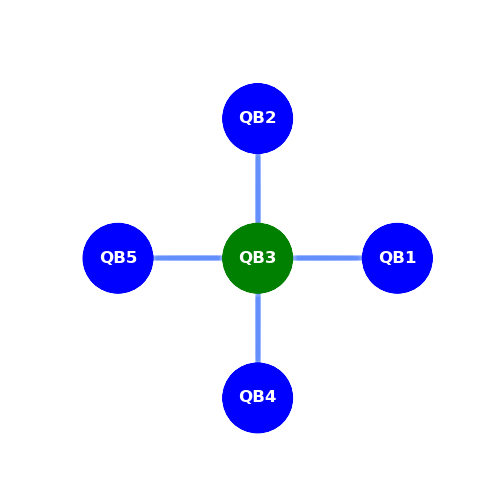

We see that in the star topology of Helmi, QB3 is the central qubit and is connected to outer qubits (QB1, QB2, QB4, QB5) using four couplings. This means that when executing 2-qubit gates, we can only use qubits that are connected to one of these four couplings. Connecting qubits further away requires applying additional quantum gates.


Next, retrieve the backend for Helmi. We have already used the Helmi quantum computer during the first day of the course, so let's follow the same routine.
In the following cell, uncomment lines based on whether you want to use real Helmi or Helmi simulator `IQMFakeAdonis`

In [2]:
## Helmi Quantum Computer------------------------------
HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
provider = IQMProvider(HELMI_CORTEX_URL)
backend_helmi = provider.get_backend()
##-----------------------------------------------------

## Helmi Simulator-------------------------------------
#from iqm.qiskit_iqm import IQMFakeAdonis
#backend_helmi = IQMFakeAdonis()
##-----------------------------------------------------

print(backend_helmi)

From the backend, we can retrieve useful information about the Helmi and print it

In [3]:
helmi_num_qubits = backend_helmi.num_qubits     # Number of qubits
helmi_couplings = backend_helmi.coupling_map       # Coupling map
helmi_gates = backend_helmi.operation_names     # Native gates
helmi_qubit_names = [backend_helmi.index_to_qubit_name(i) for i in range(helmi_num_qubits)]     # We can convert indices to IQM-style qubit names 

print(f"Backend: {backend_helmi.name}")
print(f"Number of qubits: {helmi_num_qubits}")
print(f"Qubit names: {helmi_qubit_names}")
print(f"Coupling map: {helmi_couplings}")
print(f"Native gates: {helmi_gates}")

Backend: IQMAdonisBackend
Number of qubits: 5
Qubit names: ['QB1', 'QB2', 'QB3', 'QB4', 'QB5']
Coupling map: [[0, 2], [2, 0], [1, 2], [2, 1], [2, 3], [3, 2], [2, 4], [4, 2]]
Native gates: ['r', 'id', 'cz', 'measure']


The IQM-style naming convention for qubits is [QB1, QB2, QB3, QB4, QB5], which in Qiskit indexing corresponds to [0, 1, 2, 3, 4]. When programming your own quantum circuits, it is usually preferred to use Qiskit's naming convention. 

The coupling map is formatted as a list. We see that each connection in the list twice as the coupling works in two ways.

Finally, we see that the Helmi backend supports the following operations
+ `id`: Identity gate. Note that despite being listed, this is not actually a gate but simply corresponds to the absence of a gate
+ `r`: Single-qubit R-Gate. Parameterized rotation gate for any rotation on 3D-Bloch sphere
+ `cz`: 2-qubit controlled Z-gate. Flips the phase of the target qubit if the control qubit is state $|1\rangle$
+ `measure`: Measures qubit in computational basis

Now we need a quantum circuit which we can transpile

## GHZ-state (Greenberger–Horne–Zeilinger state)

Starting from the initial state $|00...0\rangle$, and applying one Hadamard gate H and multiple CNOT gates, we can create a maximal entanglement of two quantum states, a system GHZ-state:
\begin{equation*}
|\text{GHZ} \rangle = \frac{ |00...0\rangle + |11...1\rangle }{\sqrt{2}}
\end{equation*}

Let's now build our 5-qubit GHZ circuit

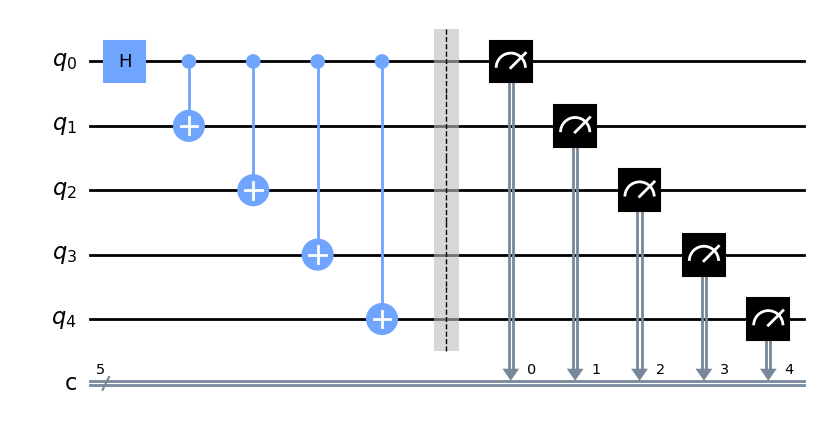

In [4]:
# Allocate 5 qubits
qc = QuantumCircuit(5,5)

# Apply Hadamard gate to the first qubit to bring it in superposition
qc.h(0)

# Apply CNOT-gates to create entangled state
qc.cx(0,1)
qc.cx(0,2)
qc.cx(0,3)
qc.cx(0,4)

# Add measurements to all qubits
qc.barrier()
qc.measure(range(5), range(5))


# Visualize
qc.draw('mpl', style="clifford")

Let's test running our GHZ-circuit at first with `Aer` simulator to see that it works as intended

In [5]:
# Retrieve backend
backend_simulator = Aer.get_backend('statevector_simulator')

# Run circuit
counts = backend_simulator.run(qc, shots=10000).result().get_counts()

# Print results
for sample in counts:
    print(f"Measurement: {sample}, Hits: {counts[sample]}, Probability: {counts[sample]/10000}")

Measurement: 11111, Hits: 4934, Probability: 0.4934
Measurement: 00000, Hits: 5066, Probability: 0.5066


## Explicit transpilation

Now we show, how one maps a circuit to a certain backend using Qiskit's `transpile` method. This is necessary when using real QPUs and simulators, which do not have universal connectivity or access to a universal set of quantum gates. In earlier examples, we did the transpilation by passing the backend as a parameter to the `transpile` method, in which case the method automatically fetches all the required information. However, we will now do this in a more explicit way to showcase the process in detail.

## `Transpile` in Qiskit

Rewrites circuit to match a topology of specific QPU, and optimizes it to reduce circuit depth and the effects of noise.

In our example, we will first use the following parameters
+ `QuantumCircuit`: The circuit we wish to transpile
+ `basis_gates`: Native operations of the backend
+ `coupling_map`: Couplings on the QPU
+ `initial_layout`: Mapping of the virtual qubits of `QuantumCircuit` to the physical qubits of the QPU

We will now use `transpile` to map our 5-qubit QHZ-circuit to Helmi, using different choices for `initial_layout`.

### Default layout

Starting off with ordered one-to-one mapping from virtual qubits to physical qubits:
$ [q_0, q_1, q_2, q_3, q_4] \rightarrow $ [QB1, QB2, QB3, QB4, QB5]

Let's transpile and print the circuit.

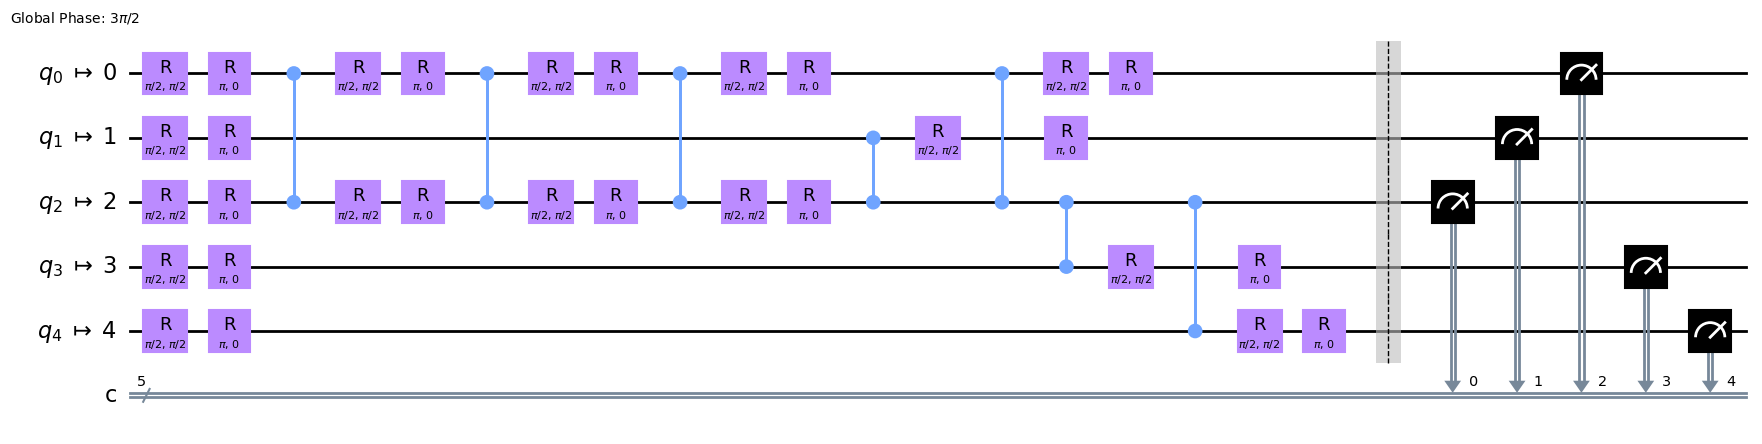

In [6]:
qc_transpiled_1 = transpile(qc, basis_gates=helmi_gates, coupling_map=helmi_couplings, initial_layout=[0,1,2,3,4])
qc_transpiled_1.draw('mpl', style="clifford")

On the left side of the circuit visualization, Qiskit displays the mapping (eg. $q_0 \rightarrow 0$), which was determined by passing the `initial_layout` parameter. All the gates in the circuit are also in line with the native gates (`r` and `cz`)

However, we see that we now have more 2-qubit operations (seven CZ gates) than what we started with (four CNOT gates). This is because the transpiler added swap gates to overcome the limited coupling.

Next, we leverage the star topology to determine a qubit layout that allows the transpilation to be done in a more optimized manner.

### Optimal layout

**Goal:** Your task is to figure out a layout that is optimal for the circuit transpilation. Fill in the answer as a list in the cell below

**Hint:** Compare the image of the Helmi qubit layout and the un-transpiled GHZ-circuit. Can you use the central qubit for the CNOT-gates?

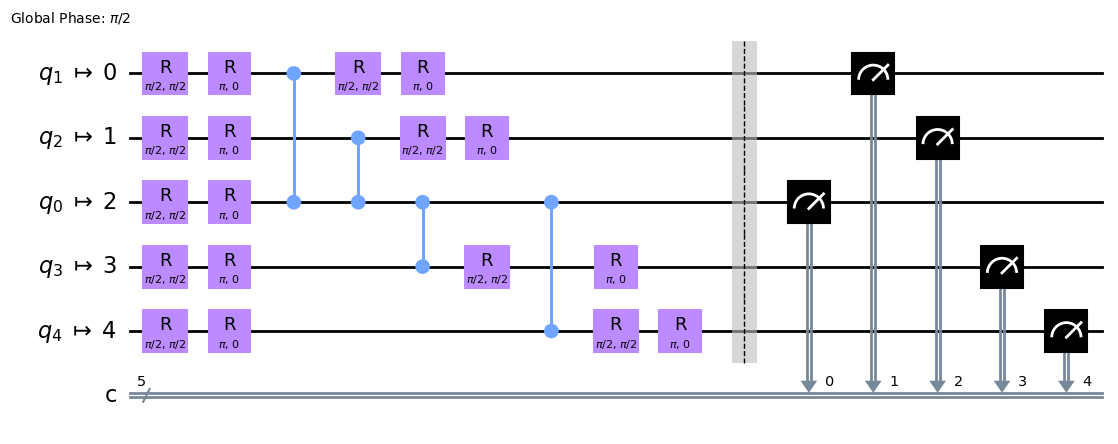

In [7]:
# Fill your answer here------
initial_layout = [2, 0, 1, 3, 4]
#----------------------------

qc_transpiled_2 = transpile(qc, basis_gates=helmi_gates, coupling_map=helmi_couplings, initial_layout=initial_layout)
qc_transpiled_2.draw('mpl', style="clifford")

If you choose the correct layout, the circuit will only contain four CZ gates

Let's run our transpiled circuit on Helmi to see if it works as intended. Some errors are to be expected, as Helmi is a real, noisy quantum computer

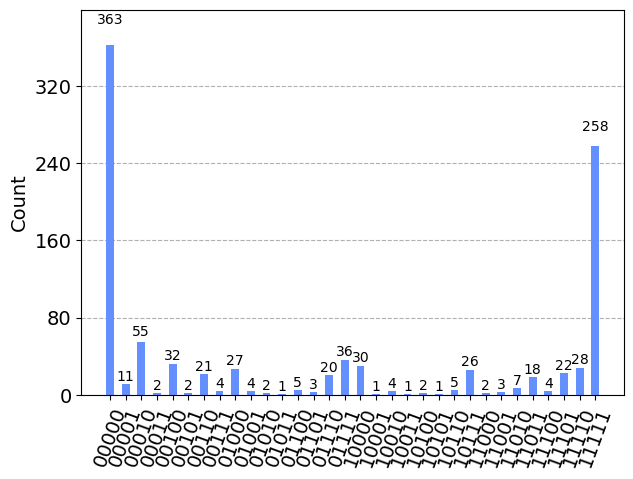

In [8]:
# Run circuit
counts_helmi = backend_helmi.run(qc_transpiled_2, shots=1000).result().get_counts()

# Plot results
plot_histogram(counts_helmi)

## More transpilation options

Qiskit's `transpile` offers a number of options for transpilation that we haven't used so far. Many of these affect how qiskit automatically tries to find the most optimal layout. For example, `layout_method` specifies how the transpiler attempts to map virtual qubits to physical qubits, taking into account the qubit connections and, if it has the information, the QPU noise profile. Then, `routing_method` tells how the transpiler tries to insert SWAP gates into the circuit in the most optimal way.

Without going too much into the details, we show an easy way to adjust the transpilation of quantum circuits by passing the parameter `optimization_level` to the `transpile` method.

`optimization_level` is an optional parameter that is passed as an integer:
+ `0`: No optimization
+ `1`: Light optimization (Default option)
+ `2`: Heavy optimization
+ `3`: Heavier optimization

Changing the level of optimization automatically affects transpiler methods such as `layout_method` and `routing_method`.
Generally, a higher level of optimization aims to make the circuit more resistant to noise if possible, but is also more computationally expensive and thus takes longer.

Below, you can try out different levels of optimization, to see how it affects our GHZ-circuit, without us giving the `initial_layout` 

**Note 1:** Our GHZ circuit is very simple, so we don't really see the difference between light, heavy, and heavier optimization levels

**Note 2:** Qiskit transpiler uses stochastic methods, so the circuit won't always be exactly the same. This can be changed by passing the parameter `seed_transpiler`

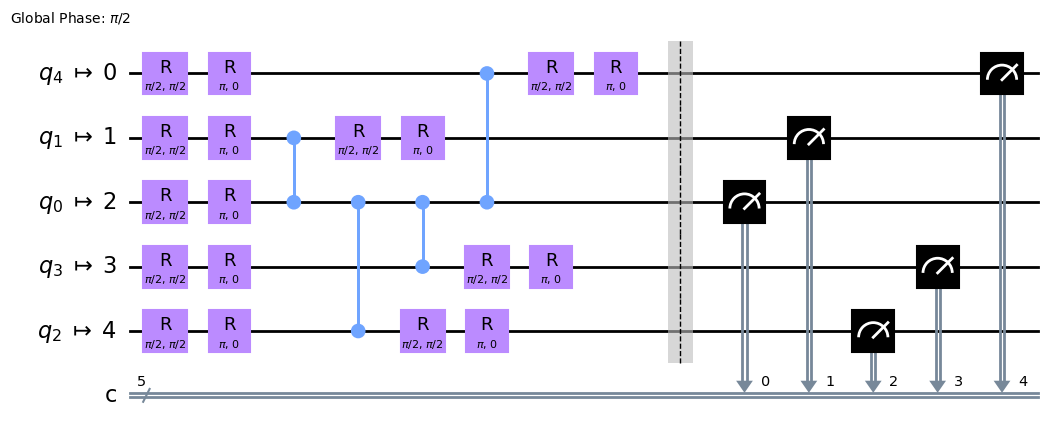

In [9]:
# Fill your answer here------
optimization_level = 1
#----------------------------

qc_transpiled_3 = transpile(qc, basis_gates=helmi_gates, coupling_map=helmi_couplings, optimization_level=optimization_level)
qc_transpiled_3.draw('mpl', style="clifford")

## Optimal circuit design is important

So far, we have shown that Qiskits' `transpile` method tries to find the best way to map the quantum circuit to physical QPU. This includes mapping virtual qubits to physical qubits, conversion of quantum gates to native gates of the hardware, and optimal insertion of SWAP gates to make up the limited connectivity. The important thing to notice is that transpilation does not re-route the 2-qubit gates, but inserts SWAP gates to implement any gate you instructed it to do. This is where it becomes important to design circuits in a hardware-aware way.

Let's demonstrate this again with GHZ-state, but this time we apply gates differently.

Complete the following cells, by creating GHZ-state, but assign CNOTs in such way that control qubit is different for all gates. Then run the circuit with `Aer` simulator to check your measurements match the state

\begin{equation*}
|\text{GHZ} \rangle = \frac{ |00...0\rangle + |11...1\rangle }{\sqrt{2}}
\end{equation*}

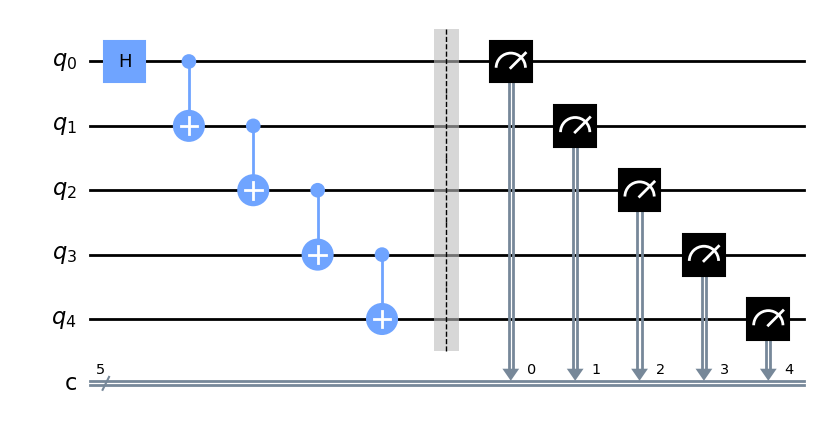

In [10]:
# Allocate 5 qubits
qc_2 = QuantumCircuit(5,5)

# Apply Hadamard gate to the first qubit to bring it in superposition
qc_2.h(0)

# Apply CNOT-gates to create entangled state
qc_2.cx(0,1)
qc_2.cx(1,2)
qc_2.cx(2,3)
qc_2.cx(3,4)

# Add measurements to all qubits
qc_2.barrier()
qc_2.measure(range(5), range(5))

# Visualize
qc_2.draw('mpl', style="clifford")

In [11]:
# Run circuit
counts = backend_simulator.run(qc_2, shots=10000).result().get_counts()

# Print results
for sample in counts:
    print(f"Measurement: {sample}, Hits: {counts[sample]}, Probability: {counts[sample]/10000}")

Measurement: 00000, Hits: 5027, Probability: 0.5027
Measurement: 11111, Hits: 4973, Probability: 0.4973


Next, keeping in mind that the transpiler does not reassign control and target qubits relative to each other, let's transpile our circuit for Helmi

In the following two cells, you will transpile our new GHZ circuit for helmi and run it

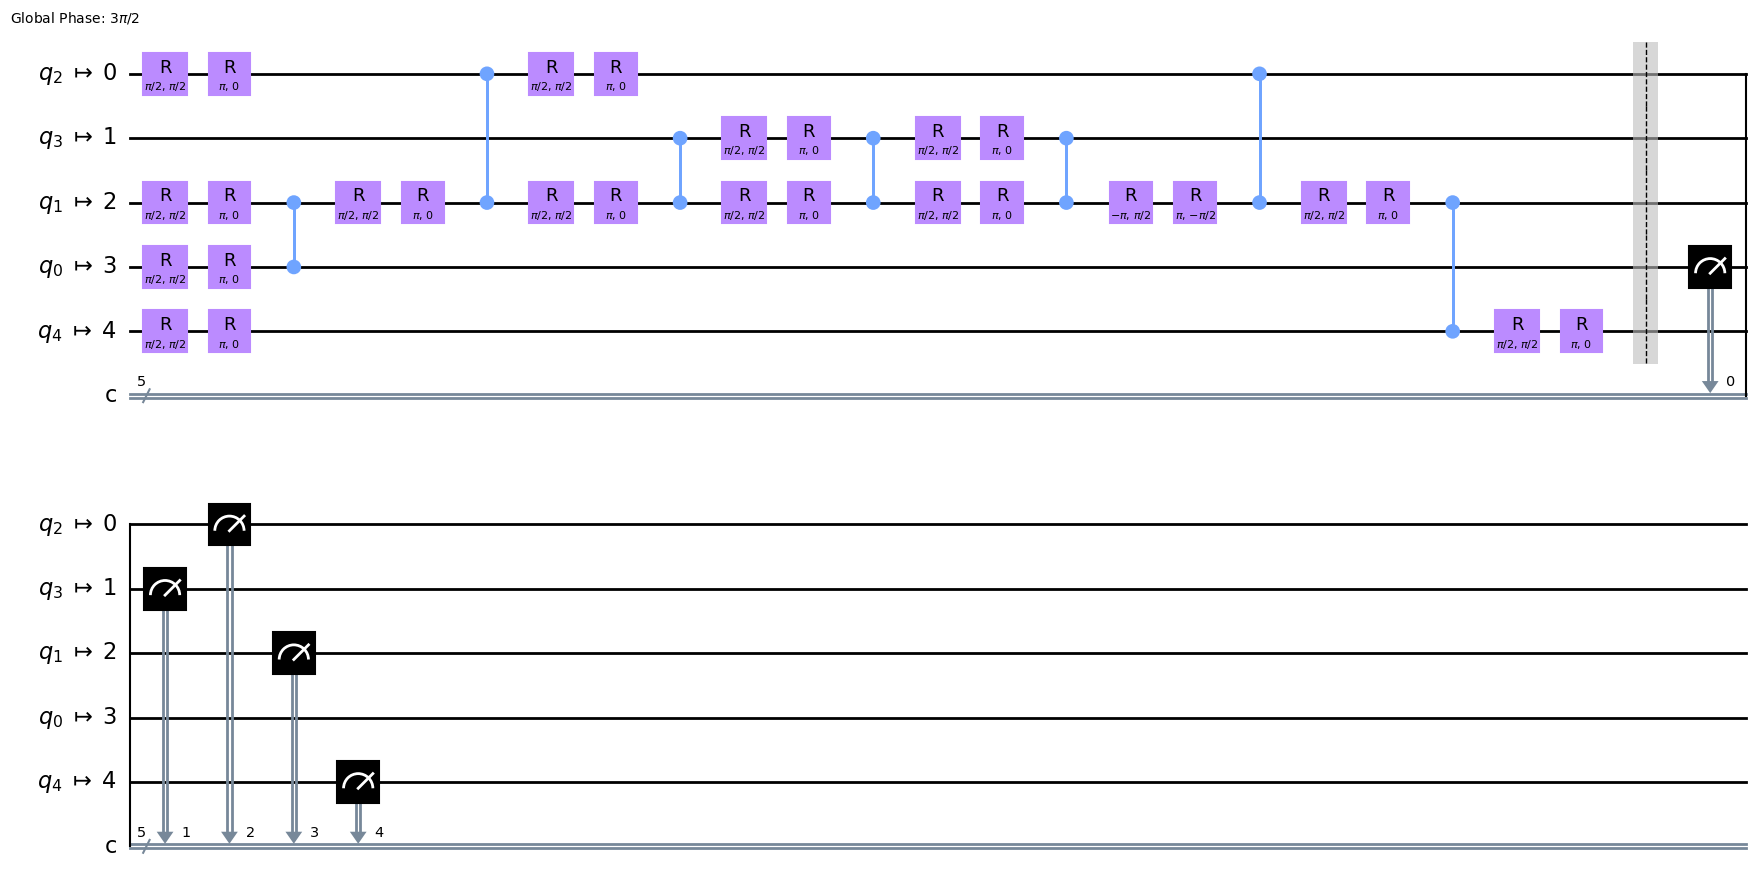

In [12]:
qc_transpiled_4 = transpile(qc_2, basis_gates=helmi_gates, coupling_map=helmi_couplings, optimization_level=3)
qc_transpiled_4.draw('mpl', style="clifford")

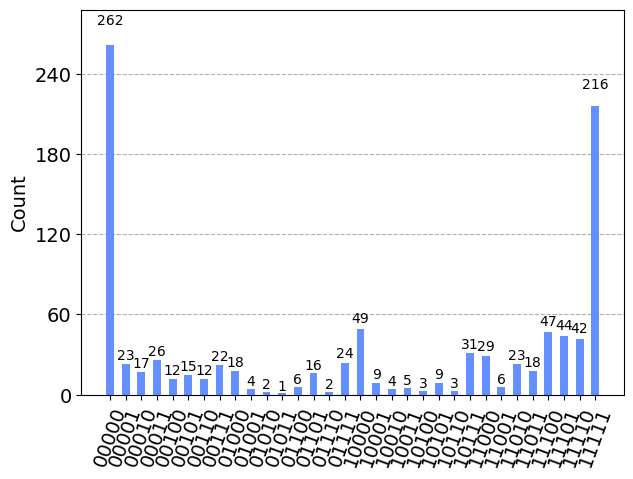

In [13]:
# Run circuit
counts_helmi = backend_helmi.run(qc_transpiled_4, shots=1000).result().get_counts()

# Plot results
plot_histogram(counts_helmi)

You should find that this new circuit cannot be transpiled as effectively.

The reason for this result is that there is no mapping from virtual qubits to physical qubits that would allow the circuit to be covered to Helmis' star topology without inserting SWAP gates. Last time, we used one qubit as a control qubit for all CNOT gates, so we could comfortably map that one qubit to the central qubit. Now, the central qubit in Helmis' star topology cannot directly be assigned to all CNOT gates.

Because this longer circuit will now, on average, experience more gate errors, we should see a bit worse results compared to our more optimal circuit.

## Takeaway

+ Transpilation maps the quantum circuit to the qubit layout and native gates of the QPU
+ In Qiskit, transpilation is done with the `transpile` method
+ User can pass parameters to the transpiler: `basis_gates`, `coupling_map`, `initial_layout`
+ Parameter `optimization_level` adjusts the level of optimization automatically
+ Heavier optimization takes more classical processing
+ Circuit desing is important for the best performance